### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [34]:
os.listdir(PATH)

DATA_FILE = "AMZN_reconstructed_features.csv"

In [64]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=12000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [65]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

print("Number of trades: ", len(regular_trades))

Number of trades:  591


In [66]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

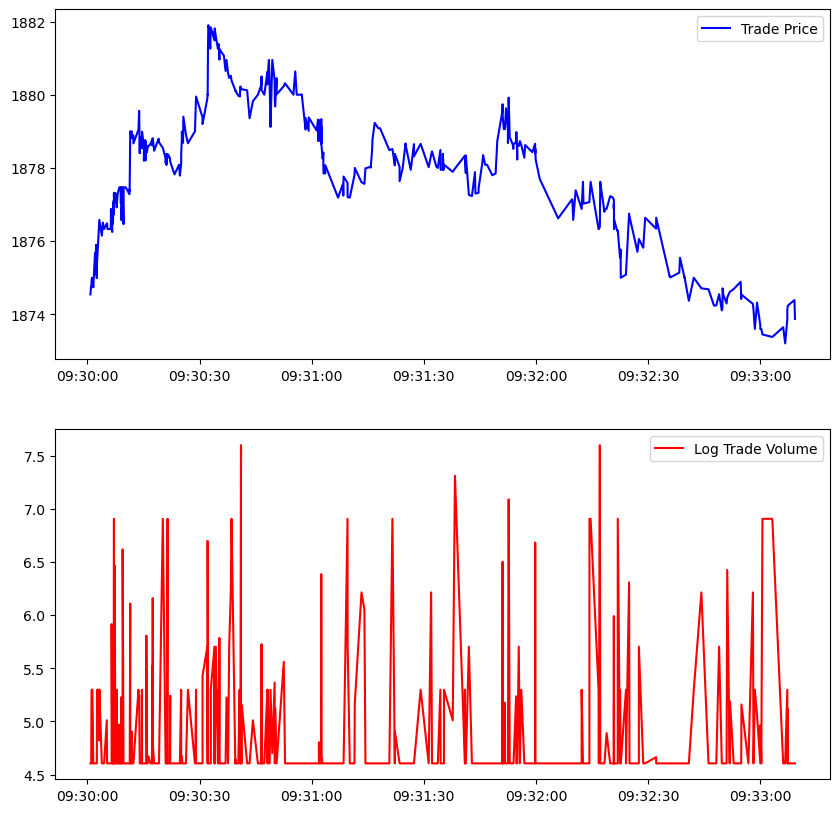

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

trade_price=regular_trades["Trade_Price"]
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(trade_price, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')

ax[0].legend()
ax[1].legend()

plt.show()



### Quick Performance of Trend Filtering

In [68]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [69]:
x=np.arange(0,len(regular_trades))
tf= Trend_Filter(x=x, y=regular_trades["Trade_Price"].values, k=1, method="primal_dual")

cv_base_estimator(tf)



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 2.522536036274926
Performing cross validation for lambda = 4.8702545962621535
Performing cross validation for lambda = 9.402989488086547
Performing cross validation for lambda = 18.154330449361787
Performing cross validation for lambda = 35.05052456797882
Performing cross validation for lambda = 67.67196817956325
Performing cross validation for lambda = 130.65411527334246
Performing cross validation for lambda = 252.25360362749257
Performing cross validation for lambda = 487.0254596262153
Performing cross validation for lambda = 940.2989488086547
Performing cross validation for lambda = 1815.4330449361767
Performing cross validation for lambda = 3505.0524567978823
Performing cross validation for lambda = 6767.196817956326
Performing cross validation for lambda = 13065.411527334232
Performing cross validation for lambda = 25225.360362749256
Performing  1 out of 3 iterations of cross validation

{'lambda_': 7.5980141531576555}

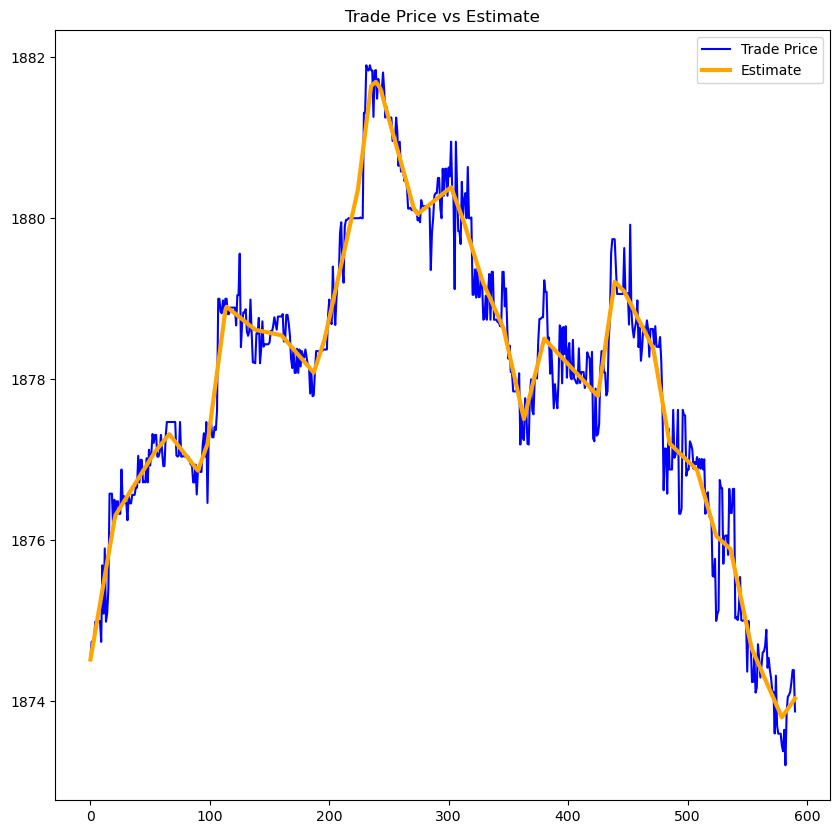

In [70]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()

ax.set_title("Trade Price vs Estimate")

plt.show()

### Regime Detection from Estimated Trend

In [71]:
from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [72]:
regime_model=Piecewise_Polynomial_Model(x=x, y=tf.y_hat, k=1, method="continous_tf")

[ 89 113 186 234 301 362 379 424 438 484 535 578]
{1: [234], 2: [234, 438], 3: [234, 424, 438], 4: [234, 379, 424, 438], 5: [113, 186, 234, 424, 438], 6: [113, 186, 234, 379, 424, 438], 7: [89, 113, 186, 234, 379, 424, 438], 8: [113, 186, 234, 301, 362, 379, 424, 438], 9: [89, 113, 186, 234, 301, 362, 379, 424, 438], 10: [89, 113, 186, 234, 301, 362, 379, 424, 438, 578], 11: [89, 113, 186, 234, 301, 362, 379, 424, 438, 535, 578], 12: [89, 113, 186, 234, 301, 362, 379, 424, 438, 484, 535, 578], 0: []}
k: 0 mse: 2.9918399180038864
k: 1 mse: 0.8643647681769195
k: 2 mse: 0.5701368483779995
k: 3 mse: 0.4992474405002983
k: 4 mse: 0.44077951806634297
k: 5 mse: 0.37749858854619506
k: 6 mse: 0.31903066611223974
k: 7 mse: 0.3073661554704511
k: 8 mse: 0.2976272622694937
k: 9 mse: 0.28596275162770507
k: 10 mse: 0.27981529211294864
k: 11 mse: 0.2901493700850182
k: 12 mse: 0.2964575048015725


In [73]:
regime_model.all_models

{0: 0.2889074254860573,
 1: 0.6596021371631183,
 2: 0.8756624693187667,
 3: 0.8828878874664549,
 4: 0.8564340516597613,
 5: 0.8451175071696976,
 6: 0.9634376507314037,
 7: 0.968315011175999,
 8: 0.9608083259818224,
 9: 0.9785025865090297,
 10: 1.0369317841567363,
 11: 1.0217409905618817}

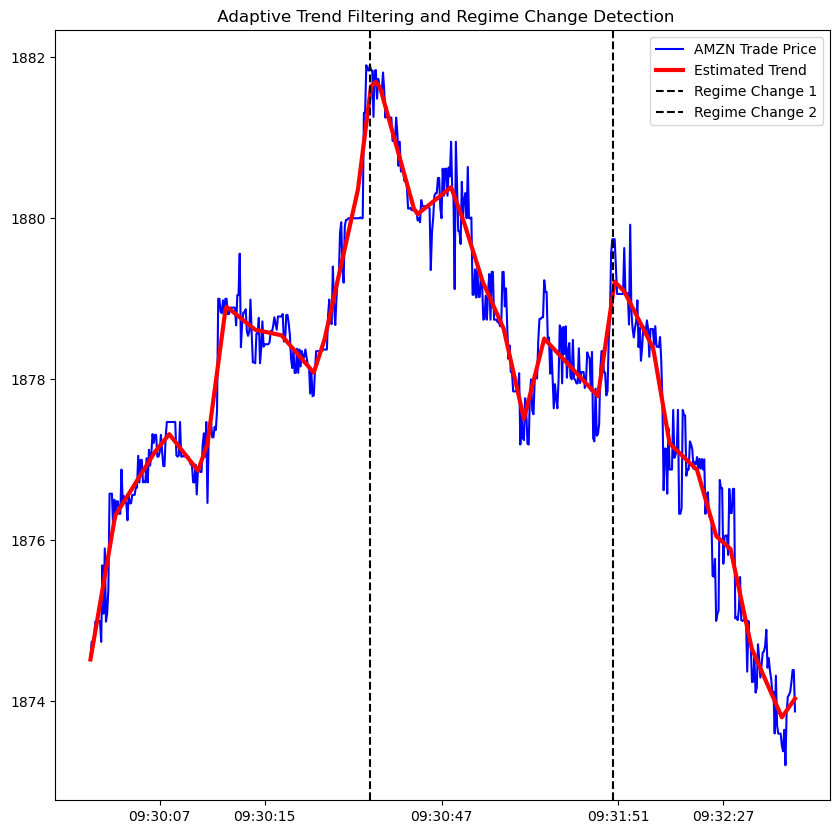

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Ratio of Loss Functions (Used for Model Selection)

In [75]:
model_selection=regime_model.all_models

model_selection

{0: 0.2889074254860573,
 1: 0.6596021371631183,
 2: 0.8756624693187667,
 3: 0.8828878874664549,
 4: 0.8564340516597613,
 5: 0.8451175071696976,
 6: 0.9634376507314037,
 7: 0.968315011175999,
 8: 0.9608083259818224,
 9: 0.9785025865090297,
 10: 1.0369317841567363,
 11: 1.0217409905618817}

Text(0.5, 1.0, 'Model Selection')

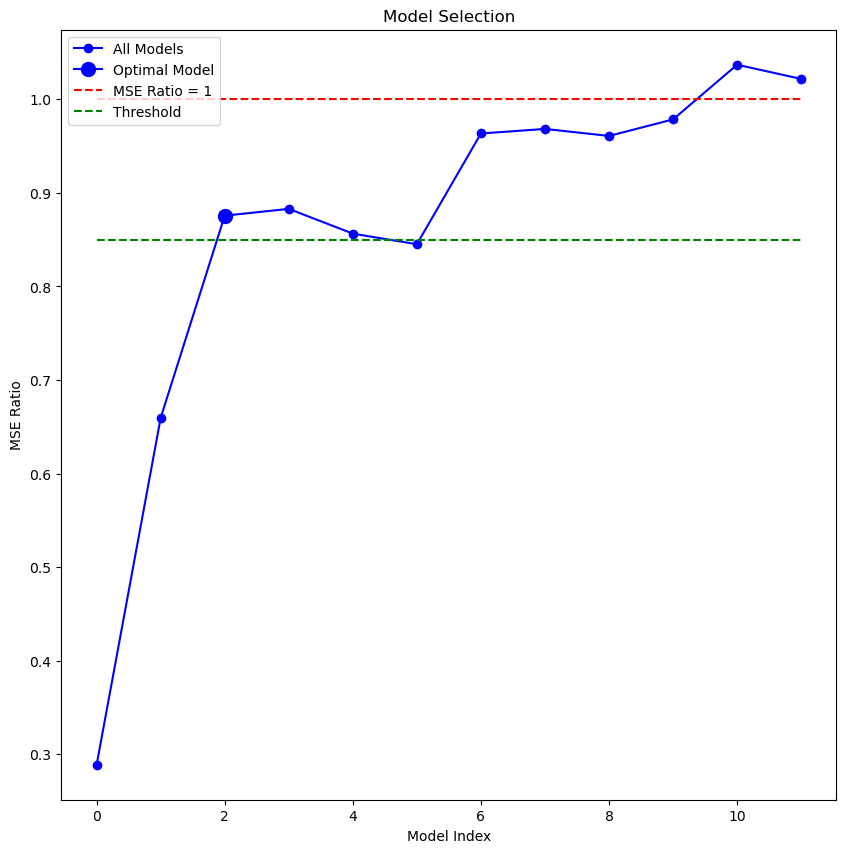

In [76]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i !=regime_model.optimal_model]


nu=regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(regime_model.optimal_model,model_selection[regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [77]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_72931/2014949561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume
Round_Timestamp,,
2020-01-02 09:30:00.820,1874.5450,100.0
2020-01-02 09:30:00.948,1874.7425,200.0
2020-01-02 09:30:01.040,1874.7400,100.0
2020-01-02 09:30:01.160,1874.9900,200.0
2020-01-02 09:30:01.180,1874.9900,200.0


In [78]:
time_trade_price=round_regular_trades["Trade_Price"]

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values




In [79]:
time_tf= Trend_Filter(x=timestamps, y=time_trade_price.values, k=1, method="primal_dual")

cv_base_estimator(time_tf)

time_tf.hypers

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.4177397267836147
Performing cross validation for lambda = 2.7372268706486835
Performing cross validation for lambda = 5.2847577025996175
Performing cross validation for lambda = 10.203269694107354
Performing cross validation for lambda = 19.699429625596352
Performing cross validation for lambda = 38.03364403843428
Performing cross validation for lambda = 73.4314701661591
Performing cross validation for lambda = 141.77397267836147
Performing cross validation for lambda = 273.72268706486835
Performing cross validation for lambda = 528.4757702599618
Performing cross validation for lambda = 1020.3269694107341
Performing cross validation for lambda = 1969.9429625596354
Performing cross validation for lambda = 3803.3644038434286
Performing cross validation for lambda = 7343.1470166159015
Performing cross validation for lambda = 14177.397267836146
Performing  1 out of 3 iterations of cross validat

defaultdict(float, {'lambda_': 2.3041357588656837})

In [80]:
time_regime_model=Piecewise_Polynomial_Model(x=timestamps, y=time_tf.y_hat, k=1, method="continous_tf")

[ 15  64  85 168 222 249 265 302 319 385]
{1: [168], 2: [168, 302], 3: [168, 302, 319], 4: [168, 265, 302, 319], 5: [15, 168, 265, 302, 319], 6: [15, 168, 249, 265, 302, 319], 7: [15, 168, 222, 249, 265, 302, 319], 8: [15, 168, 222, 249, 265, 302, 319, 385], 9: [15, 64, 168, 222, 249, 265, 302, 319, 385], 10: [15, 64, 85, 168, 222, 249, 265, 302, 319, 385], 0: []}
k: 0 mse: 2.949721543704661
k: 1 mse: 0.8913289448734292
k: 2 mse: 0.7341009198075019
k: 3 mse: 0.6020947872127218
k: 4 mse: 0.5532896904785661
k: 5 mse: 0.529917201295344
k: 6 mse: 0.5707562745266375
k: 7 mse: 0.5986097839038733
k: 8 mse: 0.6665039158853239
k: 9 mse: 0.797452207895611
k: 10 mse: 0.8906235352989218


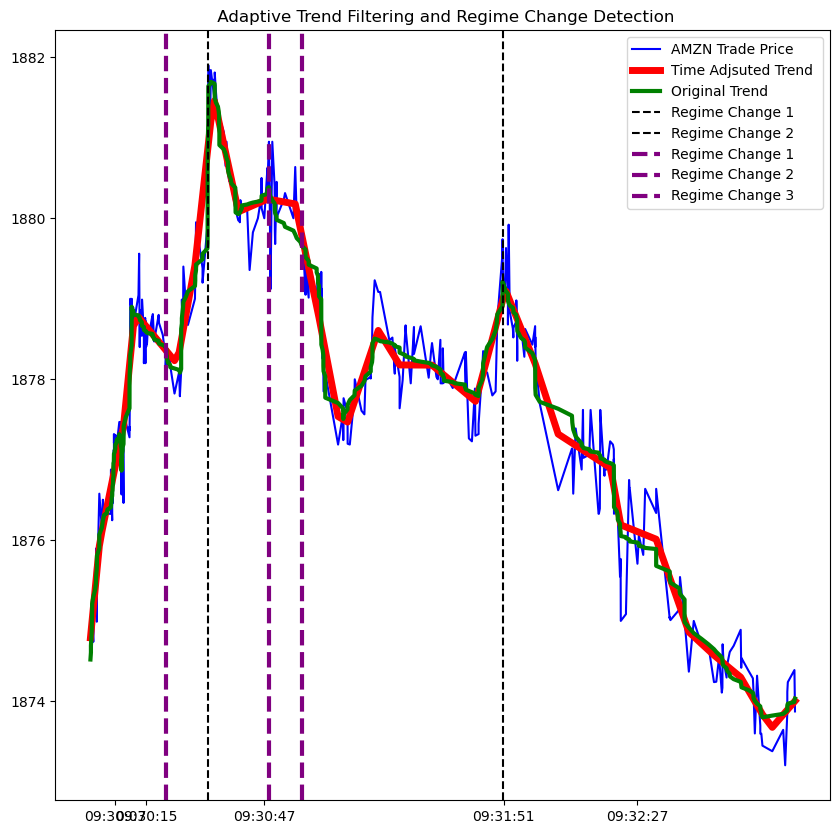

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.index,trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(time_trade_price.index,time_tf.y_hat, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(trade_price.index,tf.y_hat, label="Original Trend",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(trade_price.index[regime_model.knots[i]],color='black',linestyle='--',label=f"Regime Change {i+1}")

for i in range(len(time_regime_model.knots)):
    ax.axvline(trade_price.index[time_regime_model.knots[i]],color='purple',linestyle='--',label=f"Regime Change {i+1}",lw=3)


ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(trade_price.index[indices],regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

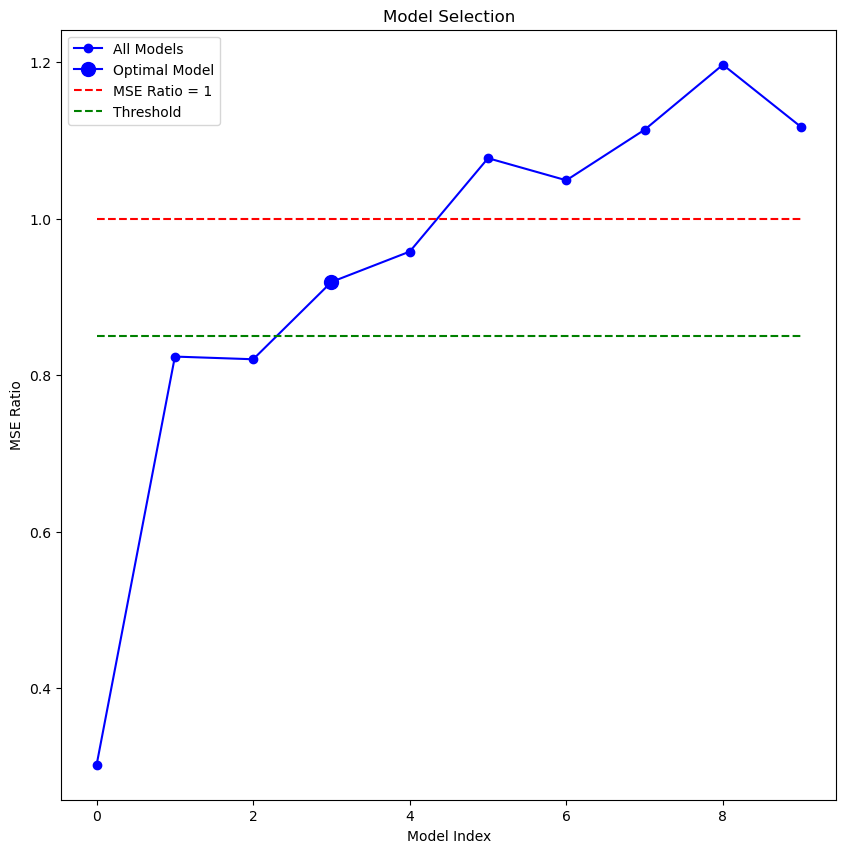

In [82]:
model_selection=time_regime_model.all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != time_regime_model.optimal_model]

nu=time_regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(time_regime_model.optimal_model,model_selection[time_regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
